In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
from nltk.tokenize import word_tokenize

In [120]:
from IPython.display import display

In [2]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SAMPLE_SUBMISSION = 'data/sample_submission.csv'
RANDOM_STATE = 25
COLORS = plt.cm.cool_r(np.linspace(0, 1, 10))

! Multioutput regression

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [4]:
train.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [6]:
FEATURE_COLUMNS = ['full_text']
TARGET_COLUMNS = ['cohesion', 'syntax','vocabulary', 'phraseology', 'grammar','conventions']

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.0,3.127077,0.662542,1.0,2.5,3.0,3.5,5.0
syntax,3911.0,3.028254,0.644399,1.0,2.5,3.0,3.5,5.0
vocabulary,3911.0,3.235745,0.583148,1.0,3.0,3.0,3.5,5.0
phraseology,3911.0,3.116850,0.655997,1.0,2.5,3.0,3.5,5.0
grammar,3911.0,3.032856,0.699841,1.0,2.5,3.0,3.5,5.0
conventions,3911.0,3.081053,0.671450,1.0,2.5,3.0,3.5,5.0


#### Target variables

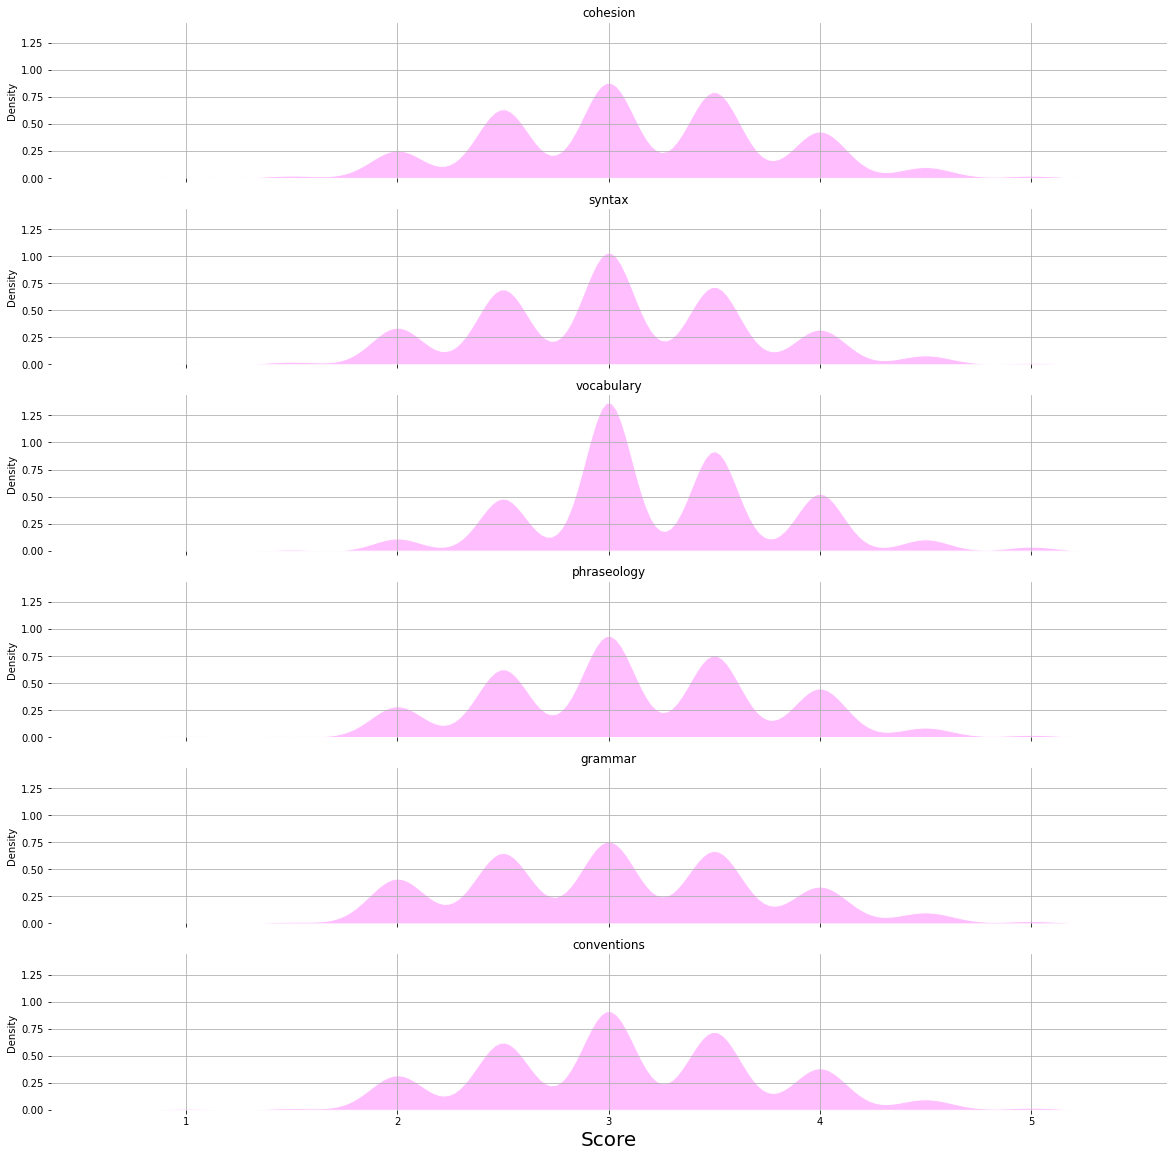

In [8]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (20, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    axs[idx].set_title(target_col)
    sns.kdeplot(train[target_col], color = COLORS[0], ax = axs[idx], fill = True, edgecolor = 'white', label = target_col)
    axs[idx].set_frame_on(False)
    axs[idx].grid(True)

plt.xlabel('Score', fontsize = 20)
plt.show()

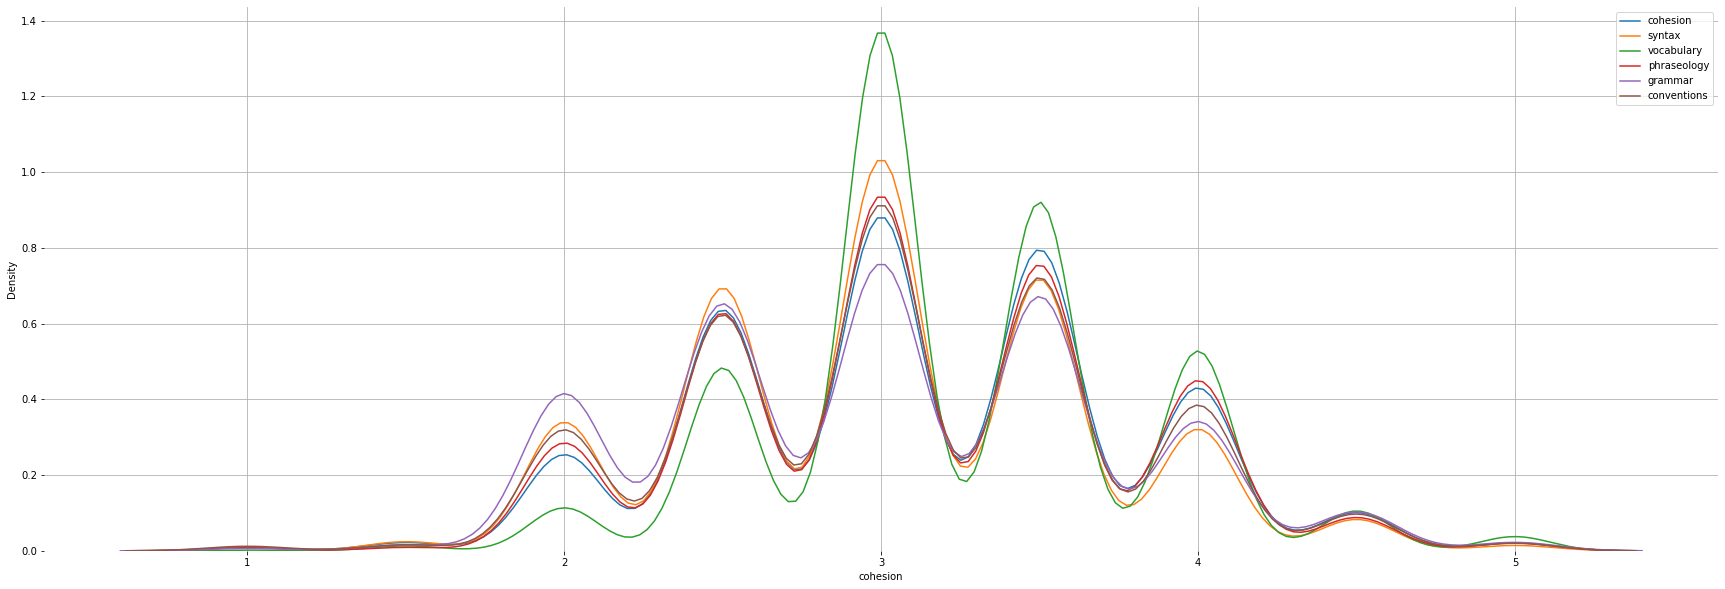

In [9]:
fig = plt.figure(figsize = (30, 10))

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.kdeplot(train[target_col], palette='cool_r', fill = False, label = target_col)

plt.box(False)
plt.grid(True)
plt.legend()
plt.show()

In [47]:
for idx, col in enumerate(train[TARGET_COLUMNS]):
    print(f"{idx}, {col} \n\t\t{sorted(train[col].unique())}")

0, cohesion 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
1, syntax 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
2, vocabulary 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
3, phraseology 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
4, grammar 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
5, conventions 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Density plots might be inappropriate as there are basically 9 unique values for each target category.

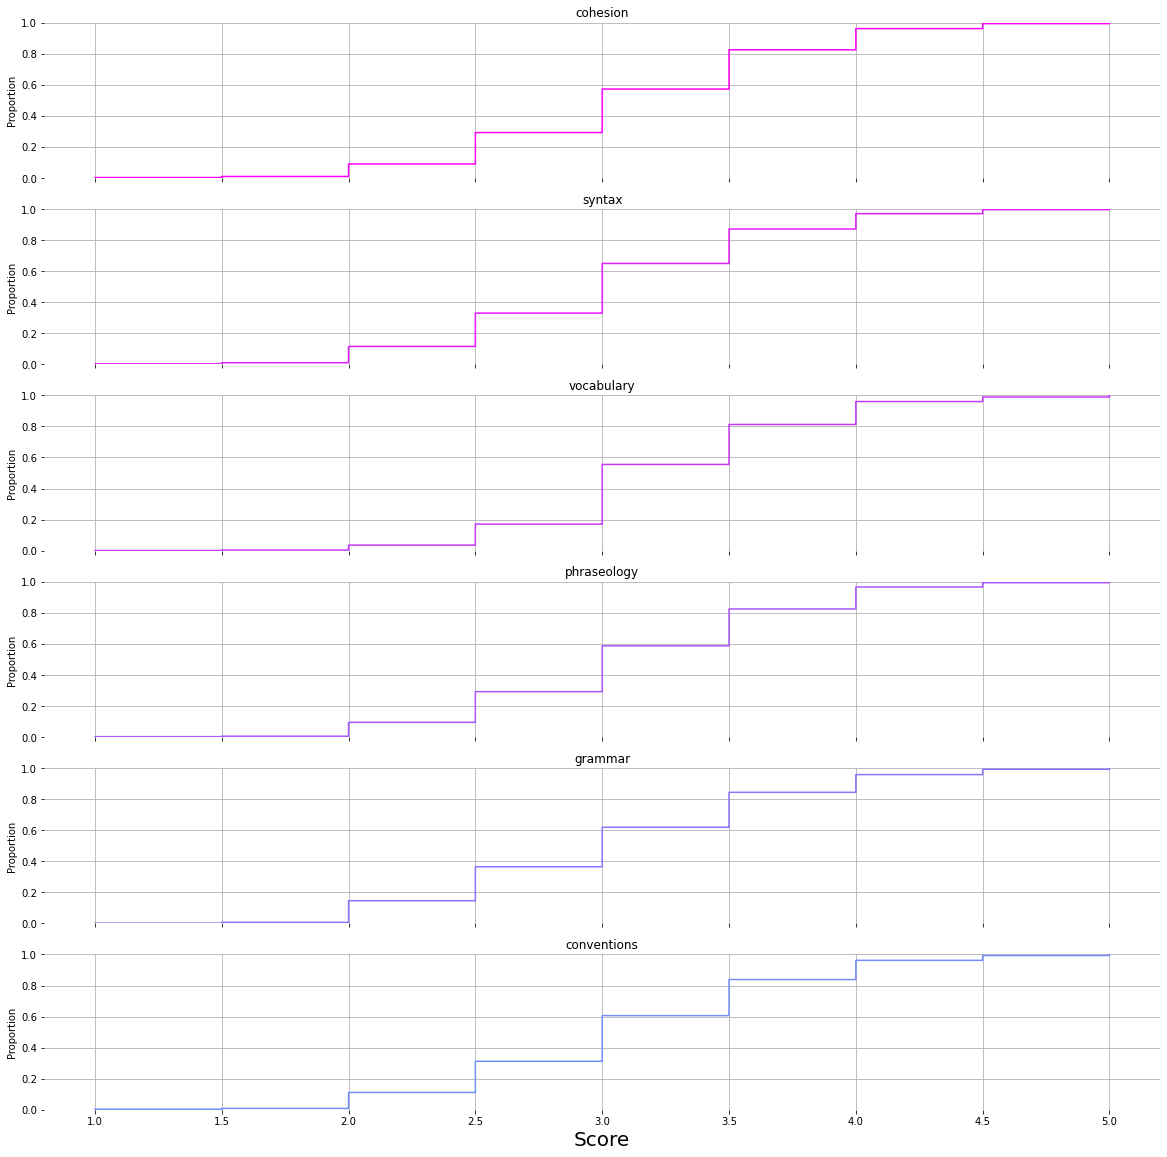

In [10]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (20, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    axs[idx].set_title(target_col)
    sns.ecdfplot(train[target_col], color = COLORS[idx], ax = axs[idx], label = target_col)
    axs[idx].set_frame_on(False)
    axs[idx].grid(True)
plt.xlabel('Score', fontsize = 20)
plt.show()

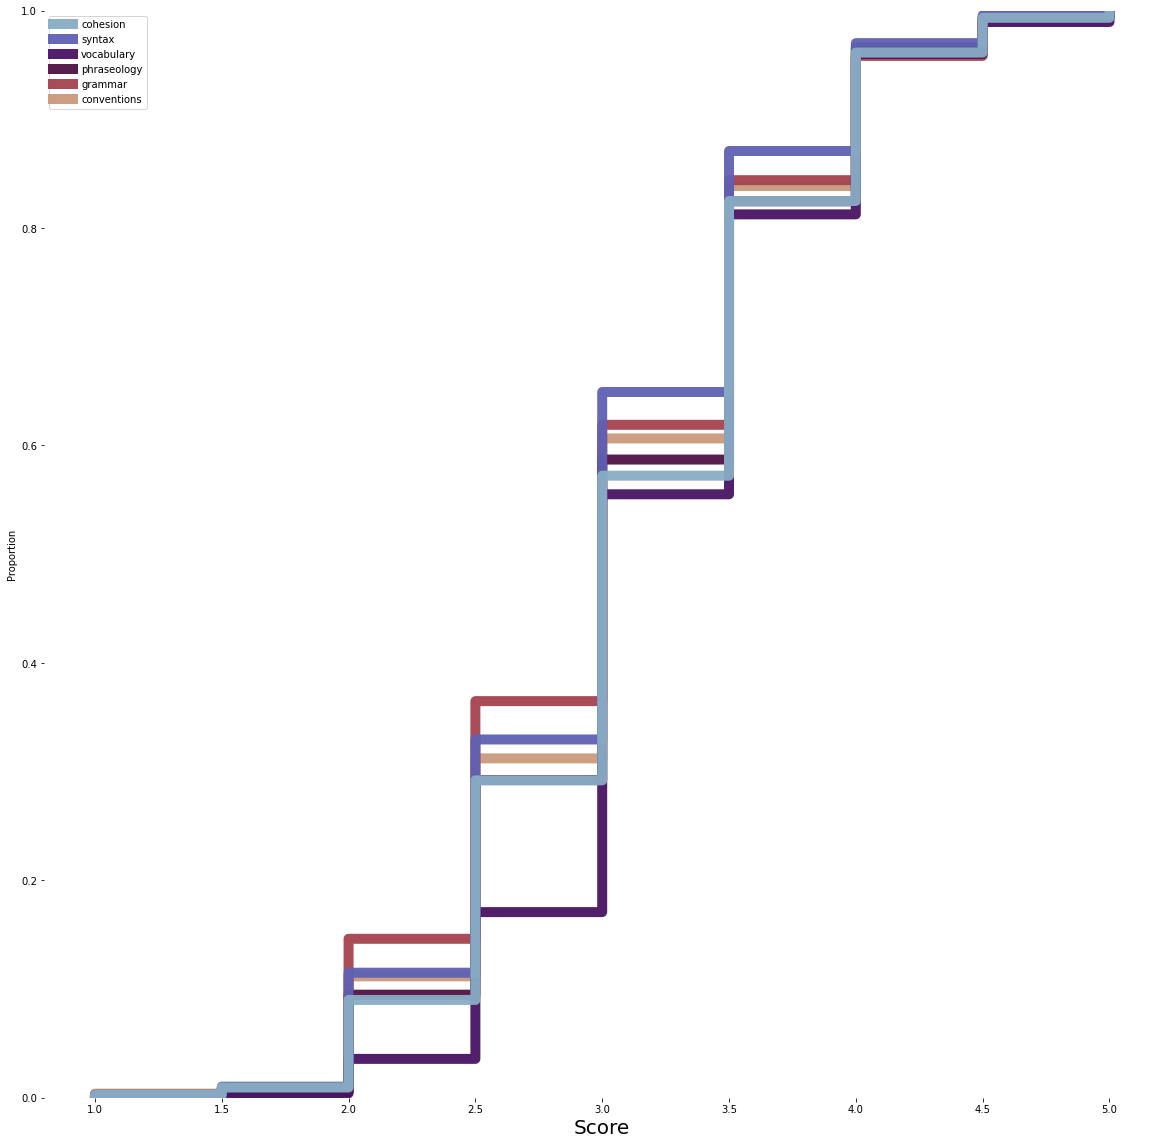

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 20))
sns.ecdfplot(train[TARGET_COLUMNS], palette='twilight', ax = axs, linewidth = 10, alpha = .95)

plt.xlabel('Score', fontsize = 20)
plt.box(False)
plt.show()

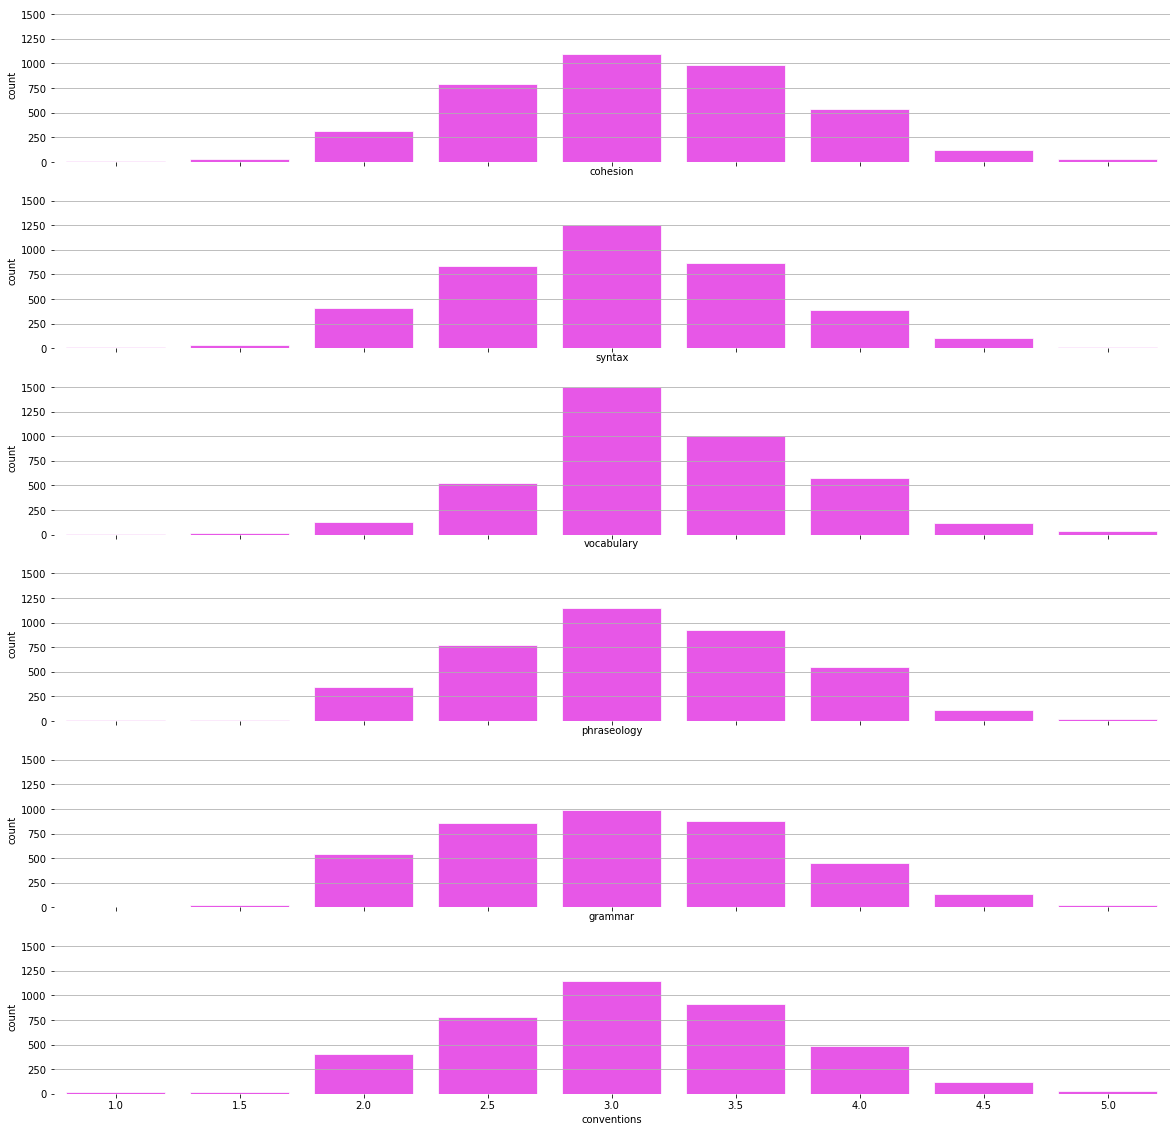

In [46]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (20, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.countplot(x = train[target_col], color = COLORS[0],  ax = axs[idx], edgecolor = 'white', label = target_col, alpha = .75, )
    axs[idx].set_frame_on(False)
    axs[idx].grid(axis='y')

plt.show()

### Text

In [49]:
tokenized_texts = train.full_text.map(word_tokenize)

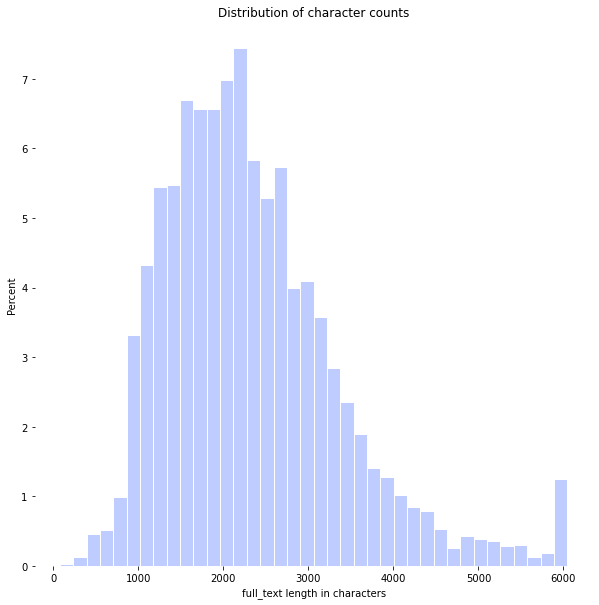

In [69]:
fig = plt.figure(figsize=(10, 10))
sns.histplot(train.full_text.str.len(), color = COLORS[-5], alpha = .45, edgecolor = 'white', stat = 'percent')
plt.xlabel(f'full_text length in characters')
plt.title('Distribution of character counts')
plt.box(False)
plt.show()

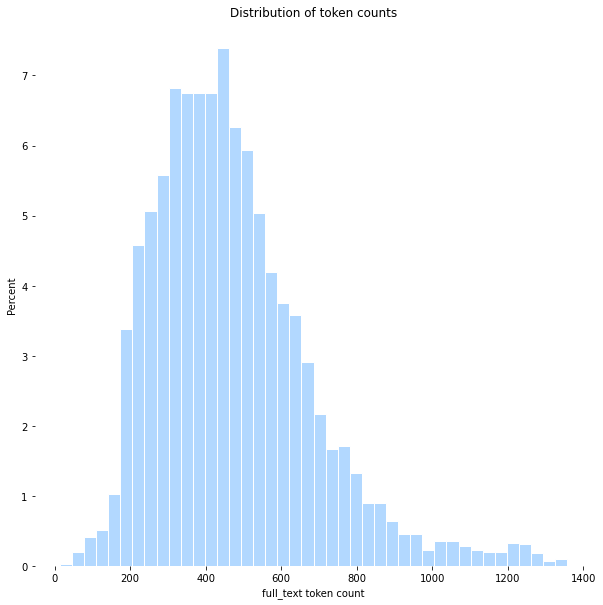

In [70]:
fig = plt.figure(figsize=(10, 10))
sns.histplot(tokenized_texts.map(len), color = COLORS[-4], alpha = .45, edgecolor = 'white', stat = 'percent')
plt.xlabel(f'full_text token count')
plt.title('Distribution of token counts')
plt.box(False)
plt.show()

In [76]:
# Let's check out some samples
samples = train.full_text.sample(10, random_state=RANDOM_STATE)
samples

3776    Thomas Jefferson once wrote "determine never b...
3596    My school should follow this model by extendin...
3218    Can failure lead to success?\n\nFormer British...
973     A diploma is a trophy we all want to have and ...
3020    If the curfew is adopted,teenargers on the str...
2526    Student should not find a career at a young ag...
2443    Many Students have become more involved and to...
2821    Boom that's the sound of a volcano that just e...
1567    A lot of people shared wisdom with me but the ...
3747    Let be honest, have you ever thought much can ...
Name: full_text, dtype: object

In [141]:
for idx in samples.index:
    
    print(f"\n\t\tSample idx: {idx}")
    target_scores = train.iloc[idx][TARGET_COLUMNS]

    print(f"\n\t\tMean target score: {target_scores.mean():.2f}")
    format_row = "{:>15}" * (len(target_scores) + 1)
    print(format_row.format("", *target_scores.index))
    print(format_row.format("", *target_scores.values))
    print(f'\n\n')
    print(train.iloc[idx].full_text)
    print(f'\n\n')
    print(100*'*')
    print(100*'*')



		Sample idx: 3776

		Mean target score: 3.42
                      cohesion         syntax     vocabulary    phraseology        grammar    conventions
                           3.0            3.0            3.5            4.0            4.0            3.0



Thomas Jefferson once wrote "determine never be idle, it is wonderful how much may be done if we are always doing.". I completely agree with this statement because if you do not want to do anything then how are you sure it will happen. If I want money and I do not have a job then how will I ever get money.

If you want a job and you only sit on your couch how will you get a job? The anwser to that question is you wont because you are not going out and applying for a job. You have to be active and you have to always keep looking until you have the job you want. Nobody will come to you and tell you

"Do you want this job?". You have to get it and if you are not doing anything to get it nobody will. In todays society people do not 